In [1]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import cross_val_score as CVS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

## 导入数据进行决策树和svm训练

In [2]:
model_woe=pd.read_csv("model_df_final.csv")
vali_woe=pd.read_csv("vali_df_final.csv")
Xtrain=model_woe.iloc[:,:-1]
Ytrain=model_woe.iloc[:,-1]
Xtest=vali_woe.iloc[:,:-1]
Ytest=vali_woe.iloc[:,-1]

### 1、决策树

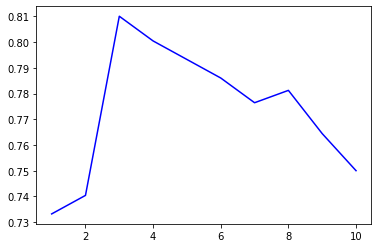

In [3]:
#看一下参数如何设置再进行网格搜索
test1=[]
for i in range(10):
    clf=DTC(max_depth=i+1).fit(Xtrain,Ytrain)
    scores=clf.score(Xtest,Ytest)
    test1.append(scores)
plt.plot(range(1,11),test1,color='b')
plt.show()

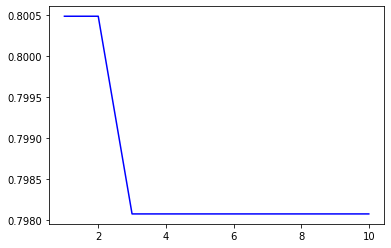

In [4]:
test2=[]
for i in range(10):
    clf=DTC(max_depth=4,min_samples_leaf=i+1).fit(Xtrain,Ytrain)
    scores=clf.score(Xtest,Ytest)
    test2.append(scores)
plt.plot(range(1,11),test2,color='b')
plt.show()

In [5]:
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(3,5,1)), 
              "min_samples_leaf": list(range(2,4,1))}
grid_tree = GridSearchCV(DTC(), tree_params)
grid_tree.fit(Xtrain, Ytrain)
clf_tree = grid_tree.best_estimator_
clf_tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
#观察有无过拟合
def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(.1,1,5)):
    if ylim is not None:
        plt.ylim(*ylim)
    train_sizes,train_scores,test_scores=learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    plt.xlabel('train sizes')
    plt.ylabel('scores')
    plt.plot(train_sizes,np.mean(train_scores,axis=1),'o-',color='r',label='train_score')
    plt.plot(train_sizes,np.mean(test_scores,axis=1),'o-',color='g',label='cross_vali_score')
    plt.legend(loc='best')
    return plt

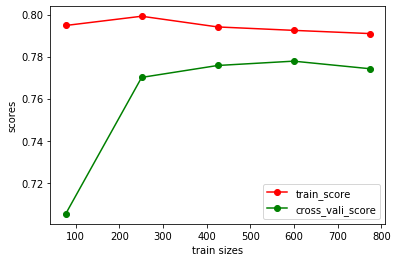

In [7]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
plot_learning_curve(clf_tree,Xtrain,Ytrain,cv=cv,n_jobs=4)
plt.show()

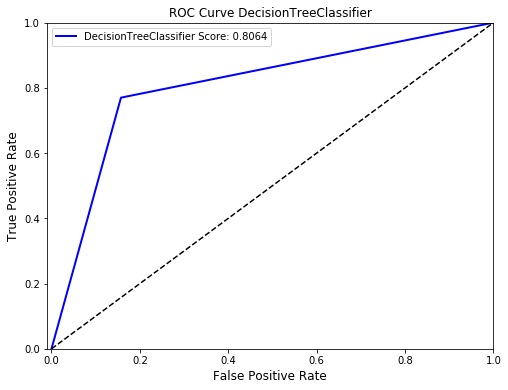

In [8]:
tree_fpr, tree_tpr, tree_threshold = roc_curve(Ytest, clf_tree.predict(Xtest))
def graph_roc_curve(fpr,tpr,title,label):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr,color='b',linewidth=2,label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.title(title)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend()
    
graph_roc_curve(tree_fpr,tree_tpr,'ROC Curve DecisionTreeClassifier'
                ,label='DecisionTreeClassifier Score: {:.4f}'.format(roc_auc_score(Ytest, clf_tree.predict(Xtest))))
plt.show()                     

ks:0.61


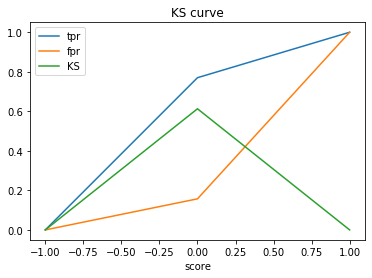

In [9]:
#计算ks值
print("ks:{:.2f}".format(max(tree_tpr-tree_fpr)))
def ks_plot(threshold,tpr,fpr):
    plt.plot(1-threshold,tpr,label='tpr')
    plt.plot(1-threshold,fpr,label='fpr')
    plt.plot(1-threshold,tpr-fpr,label='KS')
    plt.xlabel('score')
    plt.title('KS curve')
    plt.xlim=([0.0,1.0])
    plt.ylim=([0.0,1.0])
    plt.legend(loc='upper left')

ks_plot(tree_threshold,tree_tpr,tree_fpr)

In [10]:
#查看混淆矩阵，打印查准率和查全率
clf_con = confusion_matrix(Ytest,clf_tree.predict(Xtest))
pd.DataFrame(clf_con)

,0,1
0,193,36
1,43,144


In [11]:
print("查准率:{:.2f},查全率:{:.2f}".format(clf_con[0][0]/(clf_con[0][0]+clf_con[1][0])
                                     ,clf_con[0][0]/(clf_con[0][0]+clf_con[0][1])))
print("KS系数:{:.2f}".format(max(tree_tpr-tree_fpr)))

查准率:0.82,查全率:0.84
KS系数:0.61


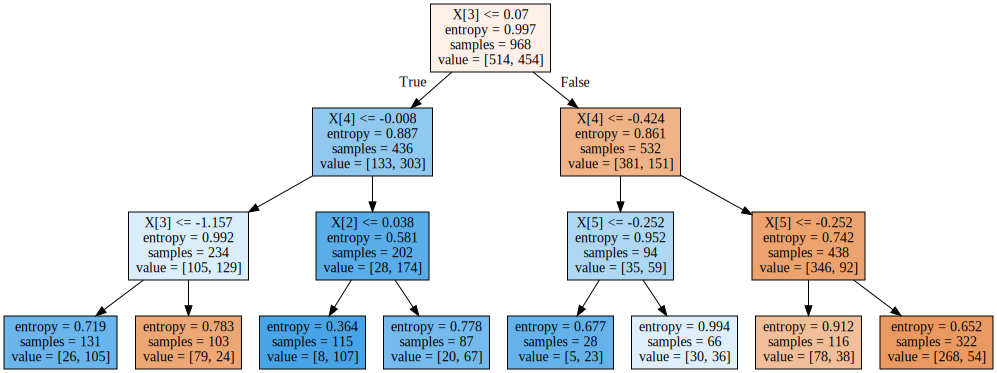

In [12]:
#决策树可视化
import graphviz
from sklearn import tree
dot=tree.export_graphviz(clf_tree,filled=True)
graphviz.Source(dot)

### 2、SVM

In [13]:
svc_params = {'C': [0.001,0.01,0.1,1], 'kernel': ['linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(Xtrain,Ytrain)
svc=grid_svc.best_estimator_
svc

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

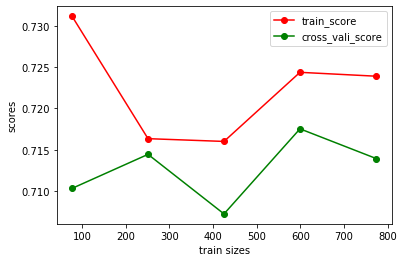

In [16]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
plot_learning_curve(svc,Xtrain,Ytrain,cv=cv,n_jobs=4)
plt.show()

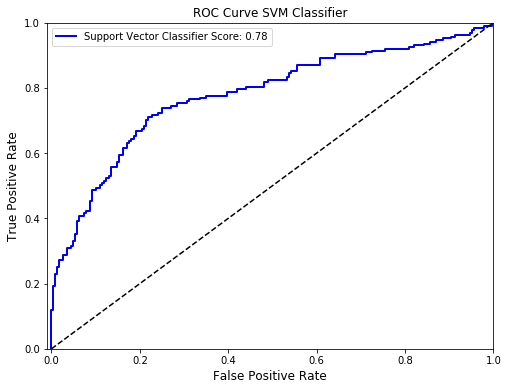

In [22]:
svc_fpr, svc_tpr, svc_threshold = roc_curve(Ytest, svc.decision_function(Xtest))
graph_roc_curve(svc_fpr, svc_tpr,'ROC Curve SVM Classifier'
                ,label='Support Vector Classifier Score: {:.2f}'.format(roc_auc_score(Ytest, svc.decision_function(Xtest))))
plt.show()

ks:0.49


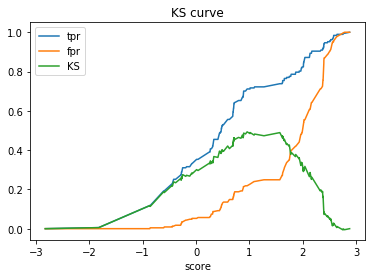

In [23]:
print("ks:%.2f"%(max(svc_tpr-svc_fpr)))
ks_plot(svc_threshold,svc_tpr,svc_fpr)
plt.show()

In [29]:
svc_con = confusion_matrix(Ytest,svc.predict(Xtest))
pd.DataFrame(svc_con)

,0,1
0,178,51
1,54,133


In [31]:
print("查准率:{:.2f},查全率:{:.2f}".format(svc_con[0][0]/(svc_con[0][0]+svc_con[1][0])
                                     ,svc_con[0][0]/(svc_con[0][0]+svc_con[0][1])))
print("KS系数:{:.2f}".format(max(svc_tpr-svc_fpr)))

查准率:0.77,查全率:0.78
KS系数:0.49
